In [ ]:
%%capture
!pip install dowhy==0.10

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import dowhy
import dowhy.api
import dowhy.datasets
import dowhy.plotter
import numpy as np

# Causal Inference with DoWhy

By Alessio Zanga, Niccolò Rocchi and Fabio Stella

## Abstract

This notebook represents a quick-start guide to causal inference using the [DoWhy](https://github.com/microsoft/dowhy) package.

## Generate a Dataset

Set the random seed generator for result reproducibility.

In [ ]:
np.random.seed(33)

DoWhy allows the generation of a dataset by specifying a set of parameters.

In [ ]:
dataset = dowhy.datasets.linear_dataset(
    beta = 3,
    num_samples = int(1e4),
    num_common_causes = 2,
    num_frontdoor_variables = 1,
    treatment_is_binary = True,
    outcome_is_binary = True
)

list(dataset.keys())

['df',
 'treatment_name',
 'outcome_name',
 'common_causes_names',
 'instrument_names',
 'effect_modifier_names',
 'frontdoor_variables_names',
 'dot_graph',
 'gml_graph',
 'ate']

It will return a dictionary with a Pandas DataFrame, along with a set of variables names and the true causal graph used for the sampling process.

In [ ]:
data, [treatment], outcome, _, _, _, _, _, causal_graph, ace = dataset.values()

After unpacking the values of the dictionary, it is possible to observe the assigned names to the data columns:

In [ ]:
treatment, outcome

('v0', 'y')

It also return the true average causal effect:

In [ ]:
ace

0.1219

In [ ]:
data

,FD0,W0,W1,v0,y
0,-0.808793,-2.038198,-0.670450,False,False
1,-0.847388,-0.719708,0.154825,False,False
2,1.871803,-0.652430,1.910733,True,True
3,-0.163010,-0.599764,0.322153,True,True
4,-2.410111,-0.728441,-0.737992,False,False
...,...,...,...,...,...
9995,2.095709,0.225739,1.332569,True,True
9996,1.251388,-1.529271,0.724498,True,True
9997,0.760808,-0.191442,-0.352940,True,True
9998,1.101175,-0.126650,1.465335,True,True


## Construct a Model

The second step consists in constructing a causal model using the true graph.

In [ ]:
model = dowhy.CausalModel(
    data = data,
    treatment = treatment,
    outcome = outcome,
    graph = causal_graph
)

It is not a proper SCM as we seen in previous sessions. It is more like a container for the data and the graph.

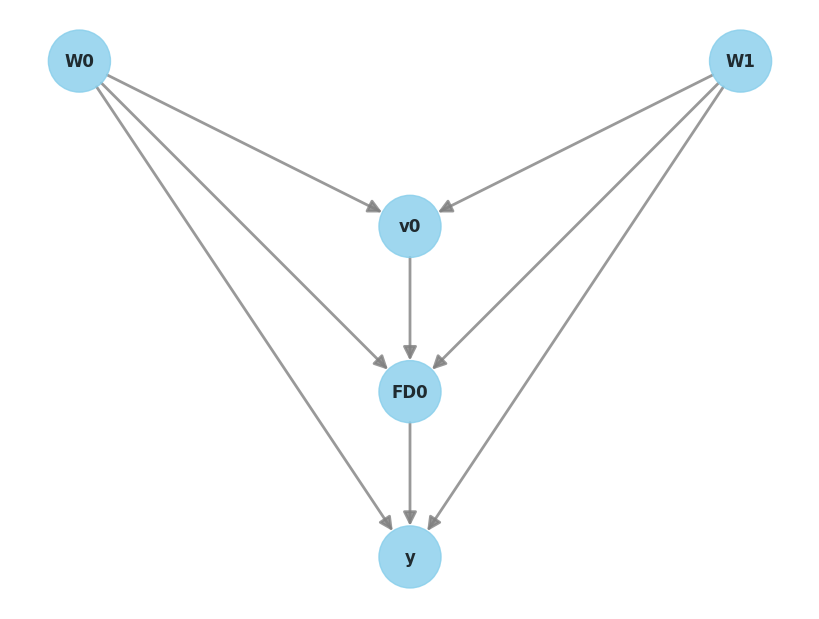

In [ ]:
model.view_model(layout="dot")
# from IPython.display import Image, display    # Run these lines if you are on local.
# display(Image(filename="causal_model.png"))

This will enable the identification step by using a couple of handful methods.

## Identify the Estimand

The estimand identification tests for both backdoor and frontdoor criterion.

In [ ]:
estimand = model.identify_effect(proceed_when_unidentifiable=True)

print(estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d              
─────(E[y|W0,W1])
d[v₀]            
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W1,U) = P(y|v0,W0,W1)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



## Estimate the Average Causal Effect

Once the estimand has been identified, we can proceed to the last estimation step.

In [ ]:
estimators = [
    "backdoor.linear_regression",
    "backdoor.propensity_score_stratification",
    "backdoor.propensity_score_weighting",
    "backdoor.propensity_score_matching",
]

We will iterate over the provided methods and compare the results.

In [ ]:
estimates = {
    estimator: model.estimate_effect(estimand, method_name=estimator)
    for estimator in estimators
}

In [ ]:
for estimate in estimates.values():
    print(estimate)
    break

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d              
─────(E[y|W0,W1])
d[v₀]            
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W1,U) = P(y|v0,W0,W1)

## Realized estimand
b: y~v0+W0+W1
Target units: ate

## Estimate
Mean value: 0.13535578974430706



In [ ]:
for estimator, estimate in estimates.items():
    print(f"""
    Estimator: {estimator},
    Estimate: {estimate.value:.4},
    Relative Error: {(abs((estimate.value-ace)/ace*100)):.4}%
    """.lstrip("\n"))

    Estimator: backdoor.linear_regression,
    Estimate: 0.1354,
    Relative Error: 11.04%
    
    Estimator: backdoor.propensity_score_stratification,
    Estimate: 0.1253,
    Relative Error: 2.751%
    
    Estimator: backdoor.propensity_score_weighting,
    Estimate: 0.1667,
    Relative Error: 36.72%
    
    Estimator: backdoor.propensity_score_matching,
    Estimate: 0.2336,
    Relative Error: 91.63%
    


## Evaluate the Results

With the estimates obtained we can setup a round of hypothesis testing. Note that, since we usually don't know the true ACE, refutation is more about the estimation procedure and not the estimate itself.

If the test's p-value is $p<0.05$, we refute the estimation; otherwise, we *don't refute* it, that is we cannot conclude anything about the correctness of the procedure. For more information, see the [DoWhy refuters page](https://www.pywhy.org/dowhy/v0.8/user_guide/effect_inference/refute.html).

In [ ]:
refuters = [
    "bootstrap_refuter",
    "data_subset_refuter",
    "dummy_outcome_refuter",
    "placebo_treatment_refuter",
    "random_common_cause",
]

We will take the backdoor with linear regression as estimate of reference.

In [ ]:
refuteds = {
    refuter: model.refute_estimate(
      estimand,
      estimates["backdoor.linear_regression"],
      method_name=refuter
    )
    for refuter in refuters
}

Some refuters may return a list of tests.

In [ ]:
for refuter in refuteds.values():
    print(refuter if type(refuter) != list else refuter[0])

Refute: Bootstrap Sample Dataset
Estimated effect:0.13535578974430706
New effect:0.13990726918337112
p value:0.6599999999999999

Refute: Use a subset of data
Estimated effect:0.13535578974430706
New effect:0.13567482620114313
p value:0.98

Refute: Use a Dummy Outcome
Estimated effect:0
New effect:0.0017584941005710025
p value:0.8999999999999999

Refute: Use a Placebo Treatment
Estimated effect:0.13535578974430706
New effect:0.0006462815620775303
p value:0.9199999999999999

Refute: Add a random common cause
Estimated effect:0.13535578974430706
New effect:0.1353529542992688
p value:1.0



We may also want to test if our estimate is significantly different from 0.

In [ ]:
print(model.estimate_effect(estimand, method_name = "backdoor.linear_regression", test_significance = True))

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d              
─────(E[y|W0,W1])
d[v₀]            
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W1,U) = P(y|v0,W0,W1)

## Realized estimand
b: y~v0+W0+W1
Target units: ate

## Estimate
Mean value: 0.13535578974430706
p-value: [1.08720934e-38]



Try to experiment with different graph configurations by altering the numbers of variables in the generation step.

Have fun!